# Using Multiplicative Weights Method to generate Buy/Sell/Hold Rating
using multiplicative weights approach to make an on-line model for stock rating and verdict.

In [64]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from news_database_interface import interface
import yfinance as yf
import pandas as pd
import yahooquery as yq
from typing import Dict, List, Tuple

In [65]:
def stock_pricing_data(ticker: str, start_date: str, end_date: str, time_frame="1mo") -> pd.DataFrame:
    """
    Fetches the pricing data for a given stock ticker from Yahoo Finance, Given a start and end date.
    """
    # get stock data
    stock = yf.Ticker(ticker)
    # get the historical data
    stock_data = stock.history(start=start_date, end=end_date)

    return stock_data

In [66]:
test_stock = 'SUZLON.NS'    # Suzlon Energy Limited, at NSE
start_date = '2021-01-01'
end_date = '2021-12-31'
stock_data = stock_pricing_data(test_stock, start_date, end_date)

In [67]:
print(stock_data.head())

                               Open      High       Low     Close    Volume  \
Date                                                                          
2021-01-01 00:00:00+05:30  6.152033  6.152033  6.152033  6.152033   2611390   
2021-01-04 00:00:00+05:30  6.427497  6.427497  6.427497  6.427497   4813374   
2021-01-05 00:00:00+05:30  6.611140  6.748872  6.106122  6.748872  62043247   
2021-01-06 00:00:00+05:30  6.978426  7.070247  6.978426  7.070247  12930305   
2021-01-07 00:00:00+05:30  7.391622  7.391622  7.391622  7.391622   4247150   

                           Dividends  Stock Splits  
Date                                                
2021-01-01 00:00:00+05:30        0.0           0.0  
2021-01-04 00:00:00+05:30        0.0           0.0  
2021-01-05 00:00:00+05:30        0.0           0.0  
2021-01-06 00:00:00+05:30        0.0           0.0  
2021-01-07 00:00:00+05:30        0.0           0.0  


In [68]:
# Get only the prices at day end
stock_data = stock_data['Close']

# Convert to numpy array
stock_data = stock_data.to_numpy()

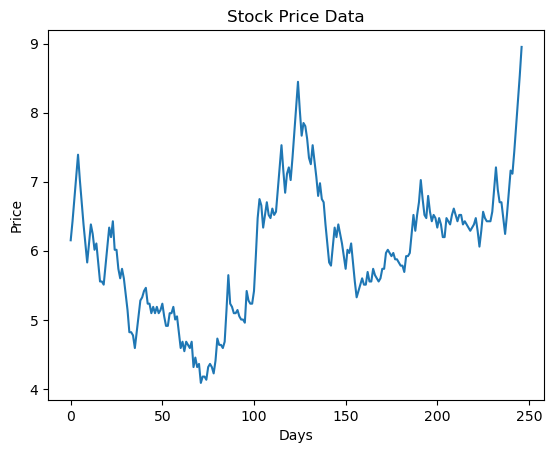

In [69]:
# Plot the stock data
plt.plot(stock_data)
plt.title('Stock Price Data')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

In [70]:
def get_firm_ratings_yf(ticker: str):
    """
    Fetches the firm (JP Morgan, Goldman Sachs, etc.) ratings for a given stock ticker from Yahoo Finance.
    """

    # get firm ratings
    stock = yf.Ticker(ticker)
    ratings = stock.recommendations
    return ratings

def get_firm_ratings_yq(ticker: str):
    """
    Fetches the firm (JP Morgan, Goldman Sachs, etc.) ratings for a given stock ticker from Yahoo Query.
    """

    # get firm ratings
    query = yq.Ticker(ticker)
    ratings = query.recommendation_trend
    return ratings

In [71]:
firm_ratings = get_firm_ratings_yf(test_stock)
yf_object = yf.Ticker(test_stock)

firm_ratings = get_firm_ratings_yq(test_stock)
print(firm_ratings)

              period  strongBuy  buy  hold  sell  strongSell
symbol    row                                               
SUZLON.NS 0       0m          1    2     3     0           0
          1      -1m          1    2     3     0           0
          2      -2m          2    2     2     0           0


# Ratings and Losses of expert
Ratings are modeled by continuous values between -1 to 1. It is to be interpetted as the confidence the expert has in the stock growing/falling.

The loss to be uses is $(\tanh(ag) - r)^2$, where $g$ is the actual growth of the stock, and r is the rating given by the expert, $a$ is a hyperparameter to be set according to the frequency of transaction sessions. (usually one of daily, weekly, mothly, quaterly, annually)


In [72]:
def rating_loss_function(expert_rating: float, growth: float, capping_parameter=10) -> np.ndarray:
    """
    Computes loss for rating
    """
    return (np.tanh(capping_parameter * growth) - expert_rating) ** 2

# Model Rating
weights are assigned to each expert, and our models rating is simply a weighted average. From this rating (value between -1 and 1), one can get buy/sell/hold verdicts by setting some thresholds.

# Updating Weights
weights of each expert are updated based on the following rule
$$w' = we^{-\eta l}$$
where $l$ is the loss incurred by the expert and $\eta$ is the learning rate hyperparameter. Exponentiation is done to counter the heavy skew which close-to-zero loss may generate.
The weights are then normalized to sum up to 1

In [73]:
def update_weight(weight: float, learning_rate: float, loss: float) -> float:
    """
    Update the weight using the gradient descent algorithm
    """
    return weight * np.exp(-learning_rate * loss)

# Model Class
We implement the discussed approach in the following class. It contains the current expert ratings and the current model rating, and upon passing new information about a session, it updates the model weights and replaces old expert and model ratings with new ones. ALong with storing relevant history

In [74]:
class StockRatingGenerator:
    """
    Generates a stock rating using the Multiplicative Weights method.

    Attributes:
        experts (Dict[str, float]): A dictionary of expert identifiers and their initial weights.
        learning_rate (float): The learning rate parameter for updating expert weights.
        capping_parameter (float): The hyperparameter to control the range of the loss function.
        history_size (int): The maximum number of historical data points to store.
        
        expert_ratings (List[Dict[str, float]]): A list of dictionaries containing the expert ratings for each session.
        model_ratings (List[float]): A list of the model's ratings for each session.
        stock_prices (List[float]): A list of the stock prices for each session.
        stock_growths (List[float]): A list of the stock growth rates for each session.
        expert_losses (List[Dict[str, float]]): A list of dictionaries containing the expert losses for each session.
    """

    def __init__(
        self,
        experts: Dict[str, float],
        learning_rate: float,
        capping_parameter: float = 10,
        history_size: int = 100
    ):
        self.experts = experts
        self.learning_rate = learning_rate
        self.capping_parameter = capping_parameter
        self.history_size = history_size

        self.expert_ratings = []
        self.model_ratings = []
        self.stock_prices = []
        self.stock_growths = []
        self.expert_losses = []

    def rating_loss_function(self, expert_rating: float, growth: float) -> float:
        """
        Computes the loss for a given expert rating and stock growth.
        
        Args:
            expert_rating (float): The rating provided by the expert.
            growth (float): The actual growth of the stock.
        
        Returns:
            float: The loss for the expert rating.
        """
        return (np.tanh(self.capping_parameter * growth) - expert_rating) ** 2

    def update_weight(self, weight: float, loss: float) -> float:
        """
        Updates the weight of an expert based on the Multiplicative Weights method.
        
        Args:
            weight (float): The current weight of the expert.
            loss (float): The loss incurred by the expert.
        
        Returns:
            float: The updated weight of the expert.
        """
        return weight * np.exp(-self.learning_rate * loss)

    def forward(self, expert_ratings: Dict[str, float], stock_price: float) -> Tuple[float, Dict[str, float]]:
        """
        Computes the model rating and updates the expert weights for the current session.

        Args:
            expert_ratings (Dict[str, float]): A dictionary of expert identifiers and their ratings.
            stock_price (float): The current stock price.
            stock_growth (float): The current stock growth rate.

        Returns:
            Tuple[float, Dict[str, float]]: The model rating and the updated expert weights.
        """
        # Compute stock growth
        stock_growth = (stock_price - self.stock_prices[-1]) / self.stock_prices[-1] if self.stock_prices else 0.0
        # Compute expert losses
        expert_losses = {
            expert: self.rating_loss_function(rating, stock_growth)
            for expert, rating in expert_ratings.items()
        }

        # Update expert weights
        updated_experts = {}
        for expert, weight in self.experts.items():
            loss = expert_losses.get(expert, 0.0)
            updated_weight = self.update_weight(weight, loss)
            updated_experts[expert] = updated_weight

        # Normalize expert weights
        total_weight = sum(updated_experts.values())
        self.experts = {expert: weight / total_weight for expert, weight in updated_experts.items()}

        # Compute model rating
        model_rating = sum(rating * weight for rating, weight in zip(expert_ratings.values(), self.experts.values())) / sum(self.experts.values())

        # Update history
        self.expert_ratings.append(expert_ratings)
        self.model_ratings.append(model_rating)
        self.stock_prices.append(stock_price)
        self.stock_growths.append(stock_growth)
        self.expert_losses.append(expert_losses)

        # Maintain history size
        if len(self.expert_ratings) > self.history_size:
            self.expert_ratings.pop(0)
            self.model_ratings.pop(0)
            self.stock_prices.pop(0)
            self.stock_growths.pop(0)
            self.expert_losses.pop(0)

        return model_rating, self.experts

In [75]:
def generate_expert_ratings(stock_growth: float, num_experts: int) -> Tuple[Dict[str, float], Dict[str, float]]:
    """
    Generates expert ratings based on different strategies.
    
    Args:
        stock_growth (float): The actual growth rate of the stock.
        num_experts (int): The total number of experts.
    
    Returns:
        Tuple[Dict[str, float], Dict[str, float]]: A tuple containing the expert ratings and the expert strategies.
    """
    expert_ratings = {}
    expert_strategies = {}

    # Generate ratings based on different strategies
    for i in range(num_experts):
        if i < num_experts // 3:
            # Rating = growth + normal noise
            rating = stock_growth + np.random.normal(0, 0.1)
            expert_ratings[f"Expert {i+1}"] = rating
            expert_strategies[f"Expert {i+1}"] = "growth + noise"
        elif i < 2 * num_experts // 3:
            # Rating = -growth + normal noise
            rating = -stock_growth + np.random.normal(0, 0.1)
            expert_ratings[f"Expert {i+1}"] = rating
            expert_strategies[f"Expert {i+1}"] = "-growth + noise"
        else:
            # Rating = normal noise
            rating = np.random.normal(0, 0.1)
            expert_ratings[f"Expert {i+1}"] = rating
            expert_strategies[f"Expert {i+1}"] = "noise"

    return expert_ratings, expert_strategies

def train_and_plot(stock_prices: List[float], num_experts: int, num_sessions: int = 100):
    """
    Trains the Multiplicative Weights model and plots the actual stock growth and the model ratings.
    
    Args:
        stock_prices (List[float]): A list of stock prices.
        num_experts (int): The total number of experts.
        num_sessions (int, optional): The number of sessions to train the model. Defaults to 100.
    """
    # Initialize the StockRatingGenerator
    experts = {f"Expert {i+1}": 1 / num_experts for i in range(num_experts)}
    rating_generator = StockRatingGenerator(experts, learning_rate=0.1)

    actual_growths = []
    model_ratings = []

    for i in range(num_sessions):
        # Generate stock growth
        stock_growth = (stock_prices[i+1] - stock_prices[i]) / stock_prices[i] if i < len(stock_prices) - 1 else 0

        # Generate expert ratings
        expert_ratings, _ = generate_expert_ratings(stock_growth, num_experts)

        # Run the model and get the updated rating and weights
        model_rating, _ = rating_generator.forward(expert_ratings, stock_prices[i])

        actual_growths.append(stock_growth)
        model_ratings.append(model_rating)

    # Plot the actual stock growth and the model ratings
    plt.figure(figsize=(12, 6))
    plt.plot(actual_growths, label="Actual Growth")
    plt.plot(model_ratings, label="Model Rating")
    plt.xlabel("Session")
    plt.ylabel("Value")
    plt.title("Actual Growth vs Model Rating")
    plt.legend()
    plt.show()

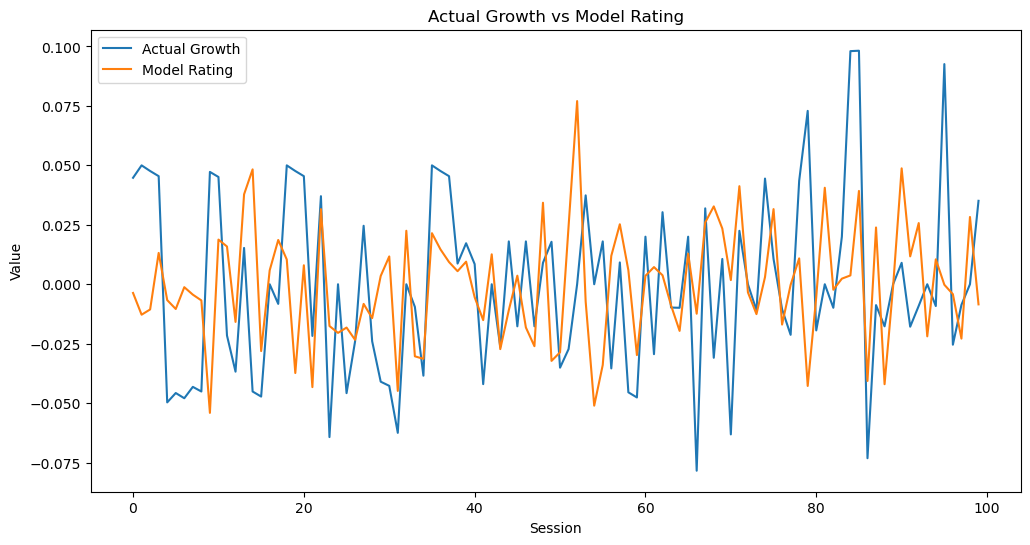

In [76]:
# Use SUZLON.NS stock data for training
# Get prices between 2021-01-01 and 2021-12-31
start_date = '2021-01-01'
end_date = '2021-12-31'
stock_prices = stock_pricing_data(test_stock, start_date, end_date)['Close'].to_numpy()

train_and_plot(stock_prices, num_experts=15)

# Interpretation
Note that the model rating is a score of the amount of confidence in direction of prediction, not a prediction of the actual growth. So we shall only be concerned with the alignment, and from the plot it is clear that the model performs decently well.